# Exploratory work and calculation of crossing points

With this notebook we examine the data to define the crossing points between the cycling routes and the infrastructure types waterway, railway and roads.

In [198]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore")

## Read the cycling network data

We make a map of the cycling networks.

In [199]:
filelist = []

for (root, directory, files) in os.walk("data/cycle_networks/"):
    for x in files:
        if x.endswith(".gpkg"):
            filelist.append(os.path.join(root,x))

df = gpd.GeoDataFrame()
for file in filelist:
    tmp = gpd.read_file(file)
    tmp= tmp.to_crs(epsg=4326)
    df = pd.concat([df,tmp])

cycle=df

## Read the infrastructure data

In [200]:
iww = gpd.read_file("data/TEN-T/iww_GL2017_EU_UK.shp")
railways = gpd.read_file("data/TEN-T/railways_GL2017_EU_UK.shp")
roads = gpd.read_file("data/TEN-T/roads_GL2017_EU_UK.shp")

# Convert coordination system
iww = iww.to_crs(epsg=4326)
railways=railways.to_crs(epsg=4326)
roads=roads.to_crs(epsg=4326)
  
# Select Benelux region
iww_benelux = iww.loc[iww["COUNTRY_CO"].isin(["BE","NL","LUX"])]
railways_benelux = railways.loc[railways["COUNTRY_CO"].isin(["BE","NL","LUX"])]
roads_benelux = roads.loc[roads["COUNTRY_CO"].isin(["BE","NL","LUX"])]

## Find the intersections

We calculate the intersections of the cycling network with the three types of infrastructure

In [201]:
i1 = iww_benelux.overlay(cycle,how="intersection",keep_geom_type=False)
i2 = railways_benelux.overlay(cycle,how="intersection",keep_geom_type=False)
i3 = roads_benelux.overlay(cycle,how="intersection",keep_geom_type=False)

all_crossings = pd.concat([i1,i2,i3])

## Get geodata

We get the geodata for Flanders region so we can place it on the map.

In [202]:
data = gpd.read_file("./data/NUTS_regions/NUTS_RG_01M_2021_4326.geojson")
data= data.to_crs(epsg=4326)
data_BE=data.loc[data['CNTR_CODE']=='BE']
data_VL=data.loc[(data['CNTR_CODE']=='BE')&(data['NUTS_ID']=='BE2')]

## Limit crossings to Flanders

We select the crossings in flanders with the three types of infrastructure

In [203]:
ww_crossings = gpd.sjoin(i1, data_VL, op='within') # Waterway crossings with cycle routes
rr_crossings = gpd.sjoin(i2, data_VL, op='within') # Railroad crossings with cycle routes
hw_crossings = gpd.sjoin(i3, data_VL, op='within') # Highway crossings with cycle routes

# Exploring infrastructure : Railways

Let's single out the railway barriers

In [204]:
infrastructure=railways
infrastructure_name="railways"
crossings=rr_crossings

## Prepare the coordinates

In [205]:
# Prepare coordinates
crossings=crossings.explode()

# Remove outliers
crossings = crossings[crossings.geometry.x <= 5.5]

In [206]:
coords = [point.coords[0] for point in crossings.geometry]

points = [Point(x, y) for x, y in coords]

## Calculate distances and plot this metric

We calculate distances between the two closest crosspoints of a cycling path with infrastructure. We then assign a normalised value to this metric and plot it on a map.

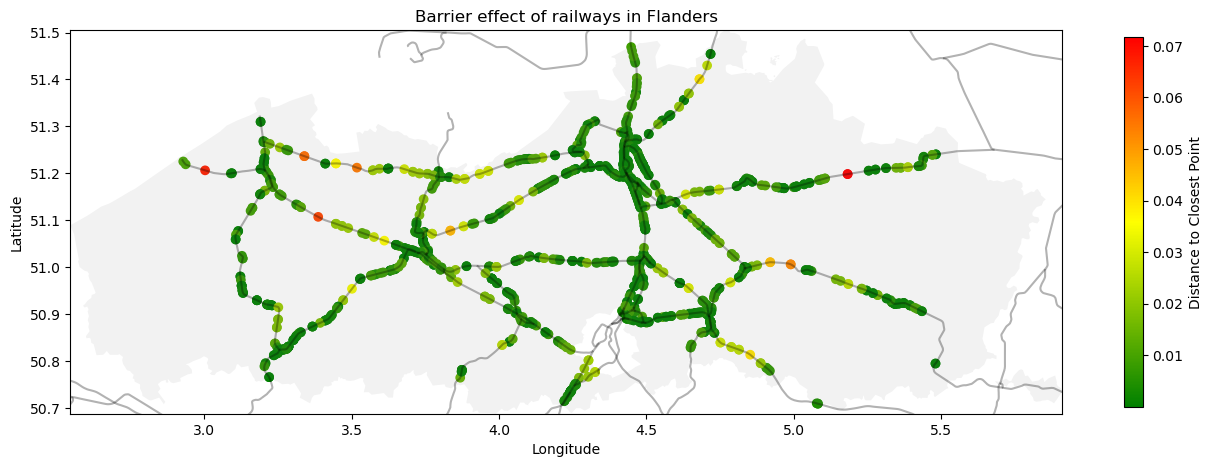

In [207]:

# Define a function to calculate the distance from a line to the closest point in a list of points
def line_min_distance(line, points):
    distances = [line.distance(point) for point in points]
    distances = [distance for distance in distances if distance != 0 ] # Exclude distance to self
    return min(distances)

# Calculate the distance from each line to the closest point
distances = crossings.geometry.apply(lambda line: line_min_distance(line, points))
 
# Map the distances to a color scale
cmap = LinearSegmentedColormap.from_list('distance', ['green', 'yellow', 'red'])
norm = plt.Normalize(vmin=distances.min(), vmax=distances.max())
colors = [cmap(norm(distance)) for distance in distances]

# Plot the GeoDataFrame using the colors
fig, ax = plt.subplots(figsize=(16,16))

# Set boundaries
bounds = data_VL.total_bounds

# Plot the data
ax = crossings.plot(color=colors, ax=ax)
ax = infrastructure.plot(color="black", alpha=0.3, ax=ax)
ax=data_VL.plot(alpha=0.1,ax=ax,color='gray' )

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Distance to Closest Point')

# Set labels and limits
ax.set_title(f"Barrier effect of {infrastructure_name} in Flanders")
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3]) 

# Show the plot
plt.show()


## Weighted metric

We now include the population density to weigh the distance metric in accordance with the relative population density. In densely populated areas the distance between crossing points should be lower, because more people will want to cross it. This evens out some points and highlights some locations where an intervience might be needed.

The weighted metric has values between 0 and 10 which we plot on the map with vmax=1 so any crossing point with a metric value above 1.0 is plotted as red value.

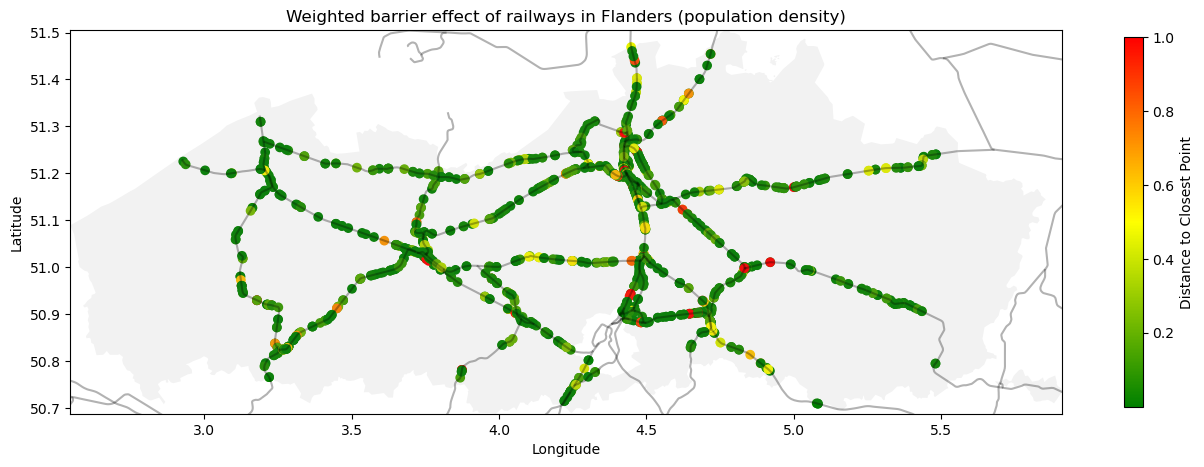

In [208]:
# Read the weighted distances
distances = pd.read_csv('data/weighted_distances.csv')
distances = distances['weighted_distance_normal']

# Map the distances to a color scale
cmap = LinearSegmentedColormap.from_list('distance', ['green', 'yellow', 'red'])
norm = plt.Normalize(vmin=distances.min(), vmax=1)
colors = [cmap(norm(distance)) for distance in distances]

# Plot the GeoDataFrame using the colors
fig, ax = plt.subplots(figsize=(16,16))

# Set boundaries
bounds = data_VL.total_bounds

# Plot the data
ax = crossings.plot(color=colors, ax=ax)
ax = infrastructure.plot(color="black", alpha=0.3, ax=ax)
ax=data_VL.plot(alpha=0.1,ax=ax, color="gray" )

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Distance to Closest Point')

# Set labels and limits
ax.set_title(f"Weighted barrier effect of {infrastructure_name} in Flanders (population density)")
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3]) 
# Show the plot
plt.show()


## New railway infrastructure

Let's have a look at railways to be built.

In [209]:
new_railways=railways[(railways['STAGE_OF_S']=="Planned")&(railways['COUNTRY_CO']=="BE")&(railways['MEASURE_TY']=="New Construction")]

We plot the railways in orange, and can take a look at their possible intersections. 

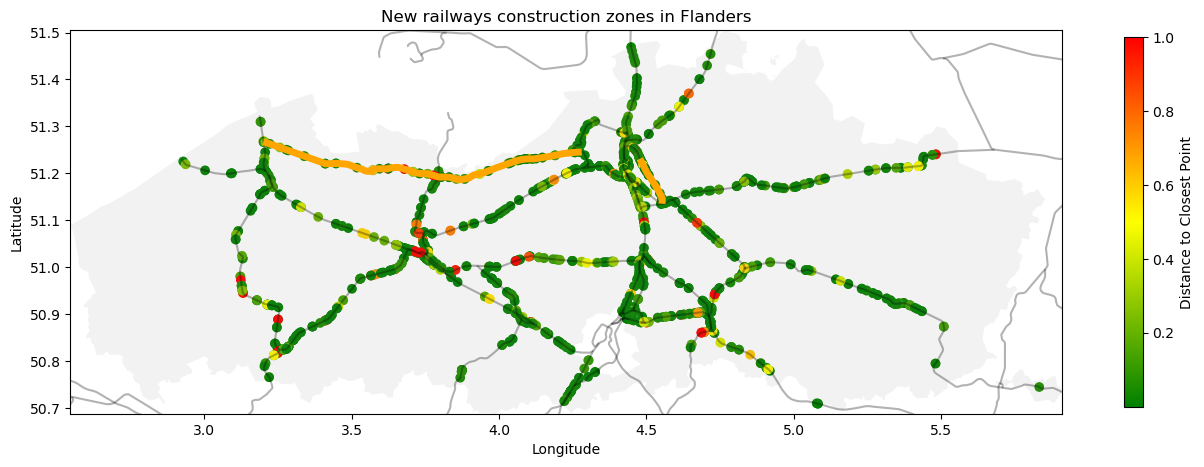

In [210]:

# Plot the GeoDataFrame using the colors
fig, ax = plt.subplots(figsize=(16,16))

# Set the boundaries
bounds = data_VL.total_bounds

# Plot the data
ax = rr_crossings.plot(color=colors, ax=ax)
ax = railways.plot(color="black", alpha=0.3, ax=ax)
ax = new_railways.plot(color="orange", ax=ax, linewidth=5)
ax=data_VL.plot(alpha=0.1,ax=ax,color='gray' )

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.3)
cbar.set_label('Distance to Closest Point')

# Set labels and limits

ax.set_title(f"New {infrastructure_name} construction zones in Flanders")
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Show the plot
plt.show()